In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, StratifiedKFold, learning_curve, RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from vecstack import stacking

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv
/kaggle/input/house-prices-advanced-regression-techniques/train.csv


In [3]:
train=pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv', index_col='Id')
test=pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv', index_col='Id')

In [4]:
print("Train data Shape = {}".format(train.shape))
print("Test data Shape = {}".format(test.shape))
train.head()

Train data Shape = (1460, 80)
Test data Shape = (1459, 79)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Finding cols with missing values

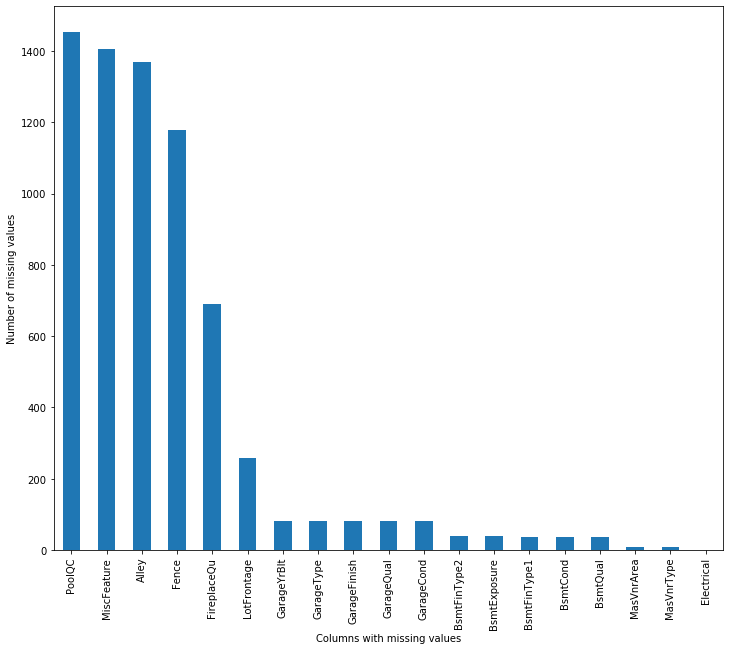

In [5]:
def missing_vals(df):
    missing=df.isnull().sum()
    missing=missing[missing>0]
    missing.sort_values(inplace=True, ascending=False)
    
    missing.plot.bar(figsize=(12,10))
    plt.xlabel('Columns with missing values')
    plt.ylabel('Number of missing values')
 

missing_vals(train)

# Filling all missing values

In [6]:
def fill_missing_vals(df):
    missing=df.isnull().sum()
    missing=missing[missing > 0]
    for column_name in list(missing.index):  # .df.index puts all the column nmaes in missing variable into single quotes
        if df[column_name].dtype=='object':   # hence easier to call them using []
            df[column_name].fillna(df[column_name].value_counts().index[0], inplace=True)
        elif df[column_name].dtype == 'int64' or 'int16' or 'float64' or 'float16':
            df[column_name].fillna(df[column_name].median(), inplace = True)

In [7]:
fill_missing_vals(train)
train.isnull().sum().max()

0

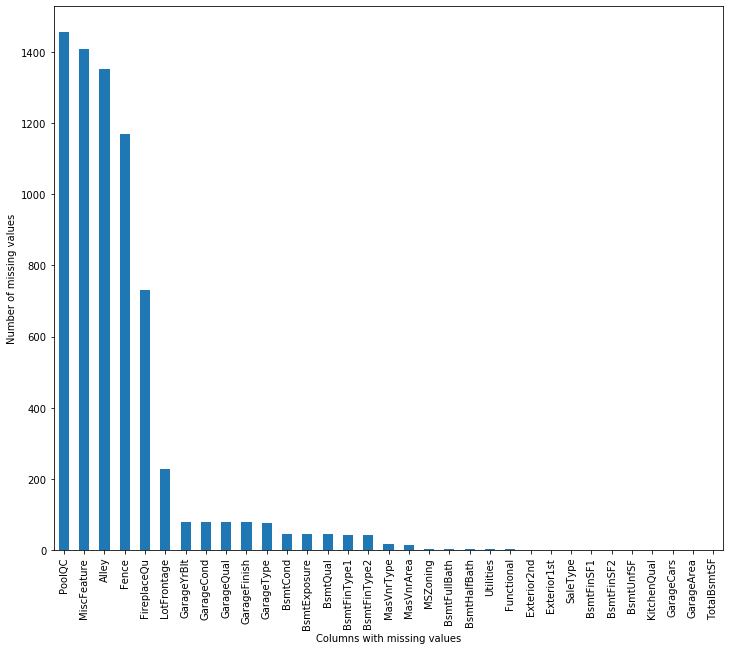

In [8]:
missing_vals(test)

In [9]:
fill_missing_vals(test)
test.isnull().sum().max()

0

In [10]:
train1=train.copy()
test1=test.copy()

# Encoding Categorical Variables

In [11]:
def encode(df):
    object_col_ind=[]
    for i in range(df.shape[1]):
        if df.iloc[:,i].dtype =='object':
            object_col_ind.append(i)
        else:
            pass
    label = LabelEncoder()
    for i in object_col_ind:
        df.iloc[:,i]=label.fit_transform(df.iloc[:,i])



In [12]:
encode(train)
encode(test)
print("Train Dtype counts: \n{}".format(train.dtypes.value_counts()))
print("Test Dtype counts: \n{}".format(test.dtypes.value_counts()))

Train Dtype counts: 
int64      77
float64     3
dtype: int64
Test Dtype counts: 
int64      68
float64    11
dtype: int64


# Visualizing the Data

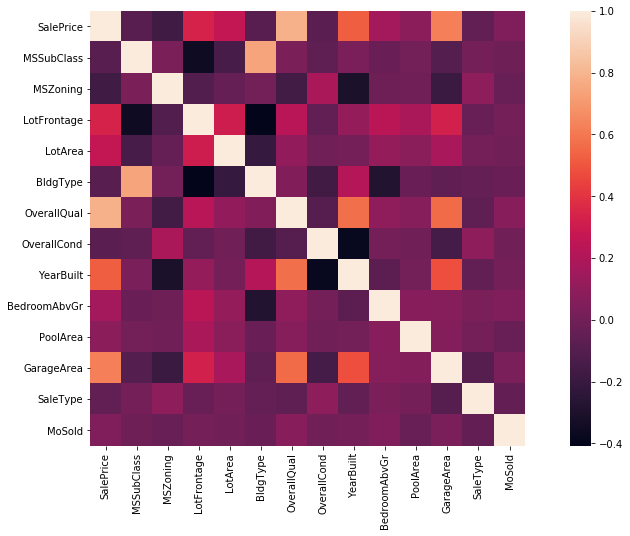

In [13]:
corr_mat = train[["SalePrice","MSSubClass","MSZoning","LotFrontage","LotArea", "BldgType",
                       "OverallQual", "OverallCond","YearBuilt", "BedroomAbvGr", "PoolArea", "GarageArea",
                       "SaleType", "MoSold"]].corr()

f, ax = plt.subplots(figsize=(16, 8))
sns.heatmap(corr_mat, vmax=1 , square=True)

/opt/conda/lib/python3.7/site-packages/seaborn/relational.py:823: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  line, = ax.plot([], [], **kws)
/opt/conda/lib/python3.7/site-packages/seaborn/relational.py:834: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  line, = ax.plot(x, y, **kws)


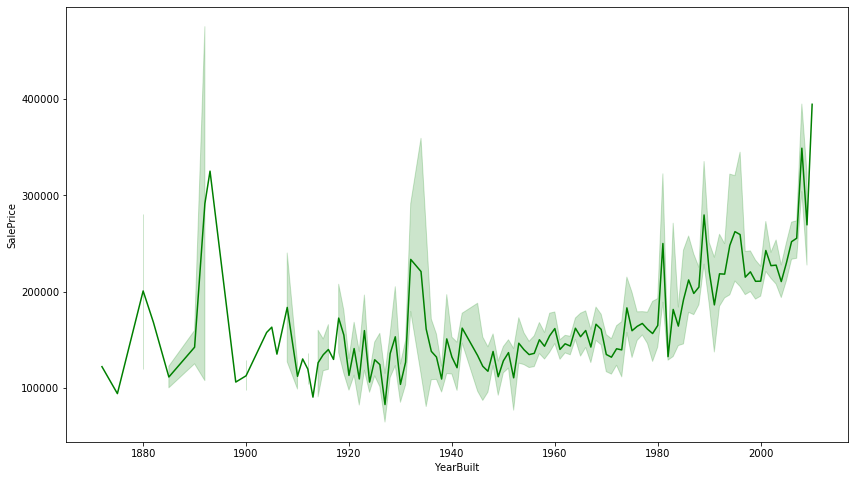

In [14]:
f,ax=plt.subplots(figsize=(14,8))
sns.lineplot(train['YearBuilt'], train['SalePrice'],c='green')

/opt/conda/lib/python3.7/site-packages/seaborn/relational.py:823: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  line, = ax.plot([], [], **kws)
/opt/conda/lib/python3.7/site-packages/seaborn/relational.py:834: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  line, = ax.plot(x, y, **kws)


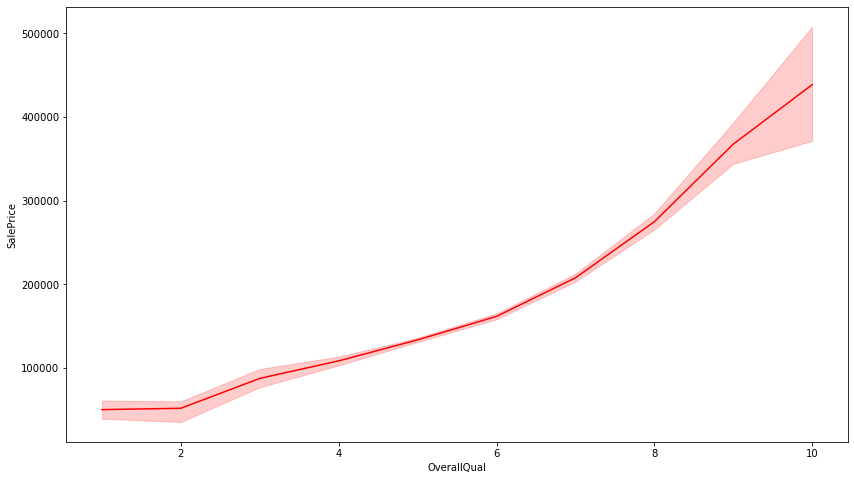

In [15]:
f,ax=plt.subplots(figsize=(14,8))
sns.lineplot(train['OverallQual'], train['SalePrice'],c='red')

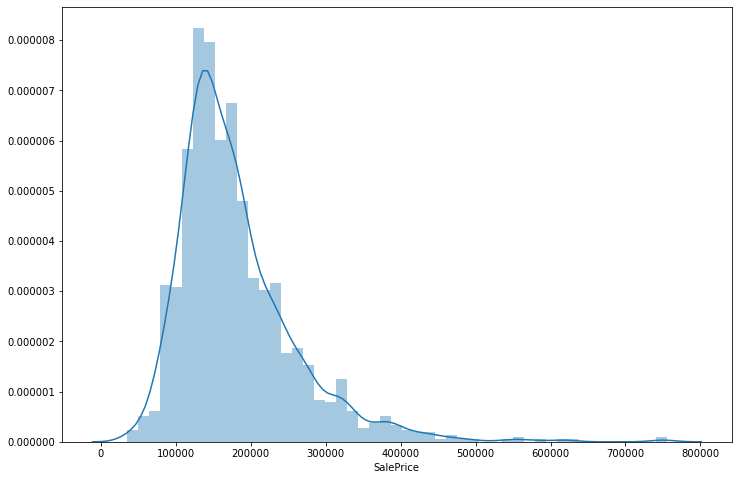

In [16]:
f,ax=plt.subplots(figsize=(12,8))
sns.distplot(train['SalePrice'])

In [17]:
X=train.drop('SalePrice', axis=1)
y =train['SalePrice']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

## Defining Evaluation Metric

In [19]:
def rmse(y,y_pred):
    return np.sqrt(mean_squared_error(np.log(y),np.log(y_pred)))

# Modelling
## We use the following Ensemble learning techniques to train and find the best model:
* GBM
* XGBoost
* RandomForest

## GBM

In [20]:
g_boost = GradientBoostingRegressor( n_estimators=6000, learning_rate=0.01,
                                     max_depth=5, max_features='sqrt',
                                     min_samples_leaf=15, min_samples_split=10,
                                     loss='ls', random_state =2
                                   )

y_pred = cross_val_score(g_boost, X, y, cv=10, n_jobs=-1)
y_pred.mean()

0.8923527470720662

In [21]:
g_boost.fit(X,y)
gbm_pred = g_boost.predict(test)
print(r2_score(g_boost.predict(X),y))
print(rmse(g_boost.predict(X),y))

0.9959519457078879
0.0351306331098917


# XGBoost

In [22]:
xg_boost = XGBRegressor( learning_rate=0.05,
                         n_estimators=1000,
                         max_depth=4, min_child_weight=1,
                         gamma=1, subsample=0.9,
                         colsample_bytree=0.2,
                         objective='reg:squarederror', nthread=-1,
                         scale_pos_weight=1, seed=7,
                         reg_alpha=0.00006
                       )


y_pred = cross_val_score(xg_boost, X, y, cv=5, n_jobs=-1)
y_pred.mean()

0.8906796735421555

In [23]:
eval_set=[(X_test,y_test)]  #to prevent overfitting
xg_boost.fit(X,y,eval_set=eval_set,eval_metric='error',verbose=False)
xgb_pred=xg_boost.predict(test)
print(rmse(xg_boost.predict(X_test),y_test))

0.030532616705391962


In [24]:
'''param={'learning_rate':[0.01,0.02,0.04],'max_depth':[3,4,5],'subsample':[0.7,0.8,0.9],
      'gamma':[1,3,5],'n_estimators':[5000,1000,3000]}

gd_cv=GridSearchCV(estimator=xg_boost,param_grid=param,n_jobs=-1,cv=5,scoring='neg_mean_squared_error')
gd_cv.fit(X,y)'''

"param={'learning_rate':[0.01,0.02,0.04],'max_depth':[3,4,5],'subsample':[0.7,0.8,0.9],\n      'gamma':[1,3,5],'n_estimators':[5000,1000,3000]}\n\ngd_cv=GridSearchCV(estimator=xg_boost,param_grid=param,n_jobs=-1,cv=5,scoring='neg_mean_squared_error')\ngd_cv.fit(X,y)"

In [25]:
'''best_parameters = gd_cv.best_params_
print(best_parameters)'''

'best_parameters = gd_cv.best_params_\nprint(best_parameters)'

In [26]:
'''submissionxgb = pd.DataFrame()

submissionxgb['Id'] = np.array(test.index)
submissionxgb['SalePrice'] = xgb_pred
submissionxgb.to_csv('submissionxgb.csv', index=False)'''

"submissionxgb = pd.DataFrame()\n\nsubmissionxgb['Id'] = np.array(test.index)\nsubmissionxgb['SalePrice'] = xgb_pred\nsubmissionxgb.to_csv('submissionxgb.csv', index=False)"

# Random Forest

In [27]:
random_forest = RandomForestRegressor(n_estimators=1200,
                                      max_depth=15,
                                      min_samples_split=5,
                                      min_samples_leaf=5,
                                      max_features=None,
                                      random_state=482,
                                      oob_score=True
                                     )

y_pred = cross_val_score(random_forest, X, y, cv=5, n_jobs=-1)
y_pred.mean()

0.8486326225066024

In [28]:
random_forest.fit(X,y)
rf_pred=random_forest.predict(test)
print(rmse(random_forest.predict(X),y))

0.09703876718445482


# Stacking

In [29]:
models=[g_boost,random_forest,xg_boost]

In [30]:
S_train, S_test = stacking(models,
                           X_train, y_train, X_test,
                           regression=True,
                           mode='oof_pred_bag',
                           metric=rmse,
                           n_folds=5,
                           random_state=25,
                           verbose=2
                          )

task:         [regression]
metric:       [rmse]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [GradientBoostingRegressor]


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


    fold  0:  [0.11316829]
    fold  1:  [0.15531809]
    fold  2:  [0.12782399]
    fold  3:  [0.11269156]
    fold  4:  [0.12650914]
    ----
    MEAN:     [0.12710221] + [0.01548438]
    FULL:     [0.12805560]

model  1:     [RandomForestRegressor]
    fold  0:  [0.13579516]
    fold  1:  [0.17127741]
    fold  2:  [0.13663400]
    fold  3:  [0.14180356]
    fold  4:  [0.14815604]
    ----
    MEAN:     [0.14673324] + [0.01304131]
    FULL:     [0.14731554]

model  2:     [XGBRegressor]
    fold  0:  [0.11135843]
    fold  1:  [0.15473451]
    fold  2:  [0.12162027]
    fold  3:  [0.11321856]
    fold  4:  [0.12147201]
    ----
    MEAN:     [0.12448076] + [0.01569431]
    FULL:     [0.12547955]



In [31]:
xgb_lev2 = XGBRegressor(learning_rate=0.05, 
                        n_estimators=500,
                        max_depth=3,
                        n_jobs=-1,
                        random_state=17
                       )

# Fit the 2nd level model on the output of level 1
xgb_lev2.fit(S_train, y_train)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.05, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=-1, num_parallel_tree=1,
             objective='reg:squarederror', random_state=17, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

In [32]:
stacked_pred = xgb_lev2.predict(S_test)
print("RMSE of Stacked Model: {}".format(rmse(y_test,stacked_pred)))

RMSE of Stacked Model: 0.1449881842930034


In [33]:
y1_pred_L1 = models[0].predict(test)
y2_pred_L1 = models[1].predict(test)
y3_pred_L1 = models[2].predict(test)
S_test_L1 = np.c_[y1_pred_L1, y2_pred_L1, y3_pred_L1]

In [34]:
test_stacked_pred = xgb_lev2.predict(S_test_L1)

# Preparing the Submission

In [35]:
submission = pd.DataFrame()

submission['Id'] = np.array(test.index)
submission['SalePrice'] = test_stacked_pred

In [36]:
submission.to_csv('submission.csv', index=False)

In [37]:
submission.head()

,Id,SalePrice
0,1461,120196.398438
1,1462,163789.078125
2,1463,189703.031250
3,1464,201731.546875
4,1465,165788.953125
...,...,...
1454,2915,75205.484375
1455,2916,76526.093750
1456,2917,166721.968750
1457,2918,120695.562500
